<a href="https://colab.research.google.com/github/Seminahn01/DS4002-Project1/blob/main/Sentimentanalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import os
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error,mean_squared_error
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

In [2]:
# Download necessary NLP data
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [3]:
# Initialize VADER
sia = SentimentIntensityAnalyzer()

In [4]:
# Load dataset
df = pd.read_csv("/content/movie_data_final.csv")

# Display dataset information
print(df.head())

   Unnamed: 0           title  review_id  \
0           1  101 Dalmatians      12794   
1           2  101 Dalmatians      12792   
2           3  101 Dalmatians      12791   
3           4  101 Dalmatians      12795   
4           5  101 Dalmatians      12793   

                                         review_text  lifetime_gross  \
0  Cast: Glenn Close, Jeff Daniels, Joely Richard...       320689294   
1  Part vamp, part tramp, and all camp, Glenn Clo...       320689294   
2  Cast: Glenn Close, Jeff Daniels, Joely Richard...       320689294   
3  Tragic, perhaps, the fate that befalls the Dis...       320689294   
4  Well, another new Disney movie is coming out a...       320689294   

   release_year  
0          1996  
1          1996  
2          1996  
3          1996  
4          1996  


In [8]:
# Ensure the OUTPUT directory exists
os.makedirs("OUTPUT", exist_ok=True)

# Save sentiment scores to CSV
df[["review_text", "sentiment_score"]].to_csv("OUTPUT/sentiment_analysis_results.csv", index=False)

print("Sentiment scores saved successfully in 'OUTPUT/sentiment_analysis_results.csv'.")

from google.colab import files
files.download("OUTPUT/sentiment_analysis_results.csv")

Sentiment scores saved successfully in 'OUTPUT/sentiment_analysis_results.csv'.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# New Section

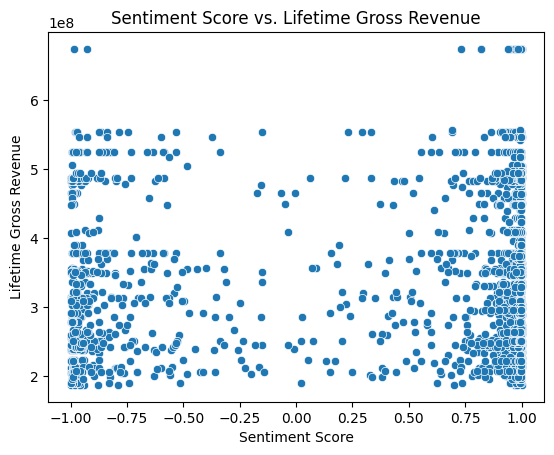

In [9]:
# Exploratory Data Analysis (EDA)
sns.scatterplot(data=df, x="sentiment_score", y="lifetime_gross")
plt.title("Sentiment Score vs. Lifetime Gross Revenue")
plt.xlabel("Sentiment Score")
plt.ylabel("Lifetime Gross Revenue")
plt.show()

In [10]:
# Reduce the number of TF-IDF features further to improve efficiency
tfidf = TfidfVectorizer(max_features=100)

In [11]:
# Transform the review text into numerical features
X_text = tfidf.fit_transform(df["review_text"].astype(str))

In [12]:
# Combine TF-IDF features with review length
df['review_length'] = df['review_text'].apply(lambda x: len(str(x)))
X_combined = hstack((X_text, df[["review_length"]]))

In [25]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_combined, df["lifetime_gross"], test_size=0.2, random_state=42)

# Train Optimized XGBoost Model (only XGBoost to avoid memory issues)
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=50, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

KeyError: 'lifetime_gross'

In [14]:
# Create a DataFrame with actual vs. predicted revenue for comparison
predictions_df = pd.DataFrame({
    "Actual Revenue": y_test.values,
    "Predicted Revenue": y_pred_xgb
})

# Display the results
print(predictions_df.head(30))

    Actual Revenue  Predicted Revenue
0        368780809        274845888.0
1        350448145        263697024.0
2        244721064        257978032.0
3        245077583        375447136.0
4        333011068        270514592.0
5        379014294        502205888.0
6        196567262        318788672.0
7        245700832        261086224.0
8        363994265        366715872.0
9        497375381        253698976.0
10       256271286        397835872.0
11       235483004        279402848.0
12       206071526        288050336.0
13       244721064        277004320.0
14       262821940        301602240.0
15       487576624        383093280.0
16       482352390        364872192.0
17       206071526        295068448.0
18       245852179        373978272.0
19       222104681        264456368.0
20       487576624        484967840.0
21       213928762        307573312.0
22       225933435        277673568.0
23       198467607        271558048.0
24       212404396        411389344.0
25       457

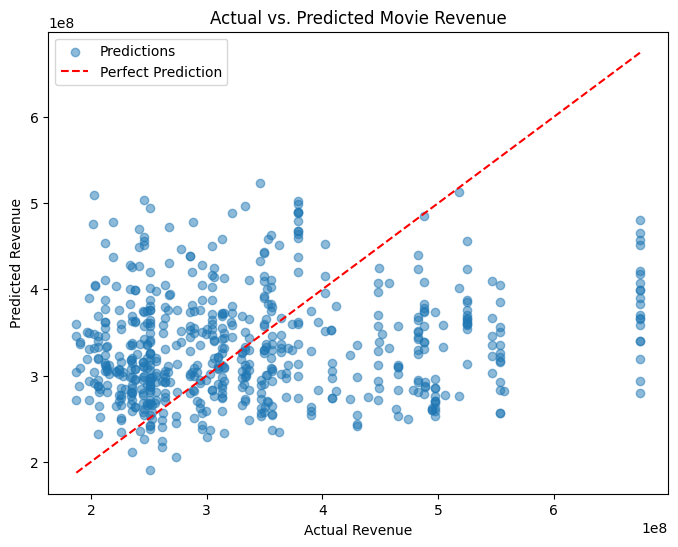

In [15]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.5, label="Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect Prediction")
plt.xlabel("Actual Revenue")
plt.ylabel("Predicted Revenue")
plt.title("Actual vs. Predicted Movie Revenue")
plt.legend()
plt.show()

In [16]:
## Multiple Linear Regression using Sentiment Score and Review Length to predict Lifetime Gross

# independent variables
x = df[['sentiment_score','review_length']]

# dependent variable
y = df['lifetime_gross']

# add constant for intercept
x = sm.add_constant(x)

# fit the regression model
model = sm.OLS(y,x)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         lifetime_gross   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     50.23
Date:                Fri, 14 Feb 2025   Prob (F-statistic):           3.44e-22
Time:                        05:29:23   Log-Likelihood:                -60788.
No. Observations:                3047   AIC:                         1.216e+05
Df Residuals:                    3044   BIC:                         1.216e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            2.875e+08   5.37e+06     

In [17]:
## Simple Linear Regression using Review Length to predict Lifetime Gross

# independent variable
x_2 = df['review_length']

# dependent variable
y_2 = df['lifetime_gross']

# add constant for intercept
x_2 = sm.add_constant(x_2)

# fit regression model
model_2 = sm.OLS(y_2,x_2)
results_2 = model_2.fit()

print(results_2.summary())

                            OLS Regression Results                            
Dep. Variable:         lifetime_gross   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     100.2
Date:                Fri, 14 Feb 2025   Prob (F-statistic):           3.09e-23
Time:                        05:29:25   Log-Likelihood:                -60788.
No. Observations:                3047   AIC:                         1.216e+05
Df Residuals:                    3045   BIC:                         1.216e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          2.883e+08   5.09e+06     56.683

In [22]:
# Predict values using the simple linear regression model
y_pred_2 = results_2.predict(x_2)

# Compute Evaluation Metrics
r2 = r2_score(y_2, y_pred_2)
mae = mean_absolute_error(y_2, y_pred_2)
mse = mean_squared_error(y_2, y_pred_2)
rmse = np.sqrt(mse)

# Print Evaluation Metrics
print("Evaluation Metrics for Simple Linear Regression (Review Length → Lifetime Gross)")
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Save regression summary to a text file
with open("OUTPUT/model_results/regression_summary.txt", "w") as f:
    f.write(results_2.summary().as_text())  # Change results_2 to your regression model variable

print("Regression summary saved successfully in 'OUTPUT/model_results/regression_summary.txt'.")

from google.colab import files
files.download("OUTPUT/model_results/regression_summary.txt")


Evaluation Metrics for Simple Linear Regression (Review Length → Lifetime Gross)
R² Score: 0.0319
Mean Absolute Error (MAE): 89742512.17
Mean Squared Error (MSE): 12472795086184888.00
Root Mean Squared Error (RMSE): 111681668.53
Regression summary saved successfully in 'OUTPUT/model_results/regression_summary.txt'.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
# Ensure the OUTPUT and model_results directories exist
os.makedirs("OUTPUT/model_results", exist_ok=True)

# Create a DataFrame for metrics
metrics_df = pd.DataFrame({
    "Metric": ["R² Score", "Mean Absolute Error (MAE)", "Mean Squared Error (MSE)", "Root Mean Squared Error (RMSE)"],
    "Value": [r2, mae, mse, rmse]
})

# Save metrics to CSV
metrics_df.to_csv("OUTPUT/model_results/model_evaluation_metrics.csv", index=False)

print("Model evaluation metrics saved successfully in 'OUTPUT/model_results/model_evaluation_metrics.csv'.")

df = pd.read_csv("OUTPUT/model_results/model_evaluation_metrics.csv")
df.head()

Model evaluation metrics saved successfully in 'OUTPUT/model_results/model_evaluation_metrics.csv'.


,Metric,Value
0,R² Score,3.186839e-02
1,Mean Absolute Error (MAE),8.974251e+07
2,Mean Squared Error (MSE),1.247280e+16
3,Root Mean Squared Error (RMSE),1.116817e+08
